# Preface

Over the past year, I had the opportunity to work with **out-of-core** datasets (larger than available memory) in both data engineering and analysis tasks.  
This article documents my experiments with Dask as a key tool for tackling these challenges.  

# 1) Simulated data for continuous data integration workflow
The raw data use for testing from [Synthetic credit card transaction data](https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions) with single .csv file ~2.3GB in size.  
To replicate continuous data ingestion, with new data come as batch in every year. The code below use to split the single csv file in to multiple files separte by Year. 

In [1]:
import os
from pathlib import Path

# Set data path to support Kaggle dataset
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') == 'Interactive':
    data_path = Path("/kaggle/input/credit-card-transactions")

In [2]:
os.listdir(data_path)

['sd254_users.csv',
 'User0_credit_card_transactions.csv',
 'sd254_cards.csv',
 'credit_card_transactions-ibm_v2.csv']

In [ ]:
import pandas as pd
import numpy as np

pdf = pd.read_csv(data_path/"credit_card_transactions-ibm_v2.csv", dtype={'Errors?': 'object'})

In [ ]:
uniq_year = pdf["Year"].unique().tolist()

In [ ]:
pdf.dtypes

In [ ]:
type(uniq_year)
uniq_year.sort()
uniq_year

In [ ]:
for y in uniq_year:
    print(y)
    yrly_ddf = pdf[pdf["Year"] == y]
    yrly_ddf.to_csv(f"/kaggle/working/yearly_data_{y}.csv", index=False)

# 2) Dask Cluster & Dashboard 

Dask could run locally without explicited cluster initiation. Anyway, suggest to explicite create cluster due to the cluster's dashboard that is very useful for monitoring and optimization dataflow.  

Some Dask version conflict with `msgpack-python` library; result in error message about the mentioned library. [To fix the issue, upgrade msgpack-python == 1.0.5](https://github.com/dask/distributed/issues/8038)  

## Cluster configuration

There are 3 important parameters : number of worker, memory config and shuffle method 

### 1) Number of worker
_Worker_ is the smallest computing unit that consist of processer and memory. Similar to Spark's worker. The computation in worker could split into _Threads_ (or cores in Spark definition). Same threads within worker share worker's memory, resulted in faster computation since no need to transfer data between worker.  
  
Dask could detect the local machine's memory and number of cores, with 4 workers as default and equally separate memory, machine core among worker. Before allocate worker's memory , Dask reserved core service for 2G first, then distribued equally among each workers. If the local machine have 16MB memory, for 4 workers ; each will have (16 - 2 (core service)) = 14 / 4 ~ 3.5G per worker.  

The number of worker could adjust by parameter **n_workers**, when Dask show _processes_ ).   

**Reference**
- [Officail doccuments](https://distributed.dask.org/en/stable/api.html#distributed.LocalCluster)
- [Threads Process](https://stackoverflow.com/questions/57760475/difference-between-dask-distributed-localcluster-with-threads-vs-processes)

### 2) Memory configuration

This will define how Dask handle data in each worker memory and when to spilled to disk / pause or terminate the worker.

distributed worker memory:  
- target: 0.60     # fraction of managed memory where we start spilling to disk  
- spill: 0.70      # fraction of process memory where we start spilling to disk  
- pause: 0.80      # fraction of process memory at which we pause worker threads  
- terminate: 0.95  # fraction of process memory at which we terminate the worker


**Reference**
- [Official doccumetns](https://distributed.dask.org/en/stable/worker-memory.html#thresholds-configuration)
- [SO on how to set memory config](https://stackoverflow.com/questions/55784232/right-way-to-set-memory-parameters-for-localcluster-in-dask)

### 3) Shuffling Method

Shuffle is the method of transferring data between worker when use dask function `sort`, `merge`, `groupby`.  
Currently Dask default on `P2P Shuffle` technics which help reduce worker memory footprint.

**Reference**
- [Official doccuments](https://docs.coiled.io/blog/shuffling-large-data-at-constant-memory.html)


In [3]:
import dask
from dask.distributed import LocalCluster
from dask import dataframe as dd

dask.config.set({ "distributed.worker.memory.target": 0.6, 
                 "distributed.worker.memory.spill": 0.7, 
                 "distributed.worker.memory.pause": 0.8, 
                 "distributed.worker.memory.terminate": 0.95,
                 "dataframe.shuffle.method": "p2p" }) 

client = LocalCluster(n_workers=4).get_client()

In [4]:
# Print the client to see the cluster information
print(client)

<Client: 'tcp://127.0.0.1:45617' processes=4 threads=4, memory=30.00 GiB>


_processs_ = number of total worker  
_threads_ = number of total thrads  
_memory_ = number of total memory

In [5]:
# Show the dashboard link, not work in kaggle
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 30.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45617,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: 1 minute ago,Total memory: 30.00 GiB
Comm: tcp://127.0.0.1:46537,Total threads: 1
Dashboard: http://127.0.0.1:37991/status,Memory: 7.50 GiB
Nanny: tcp://127.0.0.1:33413,


In [6]:
# Show the dashboard link
client.dashboard_link

'http://127.0.0.1:8787/status'

# 3) Data ingesting & configuration

Dask have capability for data integration tasks like appending parquet file or [store parquet in Hive directory format](https://docs.dask.org/en/latest/dataframe-hive.html
). We could use Dask to create datamart/datacube.    

This part explore Dask capability as above and test the query performance. All the test case use separated by year data that have create from step above.  

Also while creating datamart we also could create **Index**; but this things are similar to Pandas index than DBMS index. Correctly indexing could help Dask in some situation like `sort`, `merge`, `groupby`.

**Reference**
- [Work-around for multi-indexing in Dask](https://stackoverflow.com/questions/75915860/dask-and-best-practices-with-multiple-indices)
- [Non unique index](https://stackoverflow.com/questions/16626058/what-is-the-performance-impact-of-non-unique-indexes-in-pandas)

## a) Datamart with No Hive directory
**Configuration**
- Set index on column `Card` by each raw file ingested, since `Card` is non-unique then division in each raw file ingest need to turn off (`ignore_divisions=True`) for appending into .parquet.
- The index columns is sorted by default.
- Non-Hive style partition folder (no `partition_on` parameter)

In [7]:
schema = {
    "User": "int64",
    "Card": "int64",
    "Year": "int64",
    "Month": "int64",
    "Day": "int64",
    "Time": "string",
    "Amount": "string",
    "Use Chip": "string",
    "Merchant Name": "int64",
    "Merchant City": "string",
    "Merchant State": "string",
    "Zip": "float64",
    "MCC": "int64",
    "Errors?": "string",
    "Is Fraud?": "string"
}

In [17]:
yr_rng = list(range(1991, 2021))
data_combined = Path("data_combined_no_hive_sort_idx_no_div.parquet")

for y in yr_rng:
    print(y)
    yrly_ddf = dd.read_csv(f"/kaggle/working/yearly_data_{y}.csv", dtype=schema)
    yrly_ddf = yrly_ddf.set_index("Card", partition_size="100MB")
    
    if data_combined.exists():    
        yrly_ddf.to_parquet(data_combined, append=True, ignore_divisions=True)
    else:
        yrly_ddf.to_parquet(data_combined)

1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


### Test Query performance

In [18]:
parquet_path = Path("data_combined_no_hive_sort_idx_no_div.parquet")
ddf = dd.read_parquet(parquet_path)

In [19]:
# Number of partitions = number of raw ingested files (no need to split, due to small size)
ddf.npartitions

30

In [20]:
# Unknown divisions, since the specified not to store divisions
ddf.known_divisions

False

In [21]:
# Check index type, and name 'Card'
ddf.index.head()

Index([1, 1, 1, 1, 1], dtype='int64', name='Card')

In [22]:
# The rest of data frame columns will excluding the index
ddf.columns

Index(['User', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?'],
      dtype='object')

In [23]:
%%timeit
ddf.groupby("Card")["MCC"].nunique().compute()

The slowest run took 34.53 times longer than the fastest. This could mean that an intermediate result is being cached.
1.35 s ± 541 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
# To groupby and aggregate index column, reset_index() is needed
ddf.reset_index().groupby("User")["Card"].nunique().compute()

1.35 s ± 38.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit
ddf.groupby("Year")["Zip"].sum().compute()

The slowest run took 36.99 times longer than the fastest. This could mean that an intermediate result is being cached.
1.08 s ± 429 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%%timeit
ddf.query("Year == 2010")["User"].count().compute()

4.43 s ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


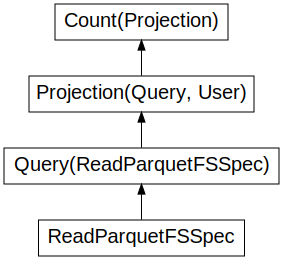

In [27]:
ddf.query("Year == 2010")["User"].count().visualize()

## b) Datamart with Hive directory

**Configuration**
- Set index on column `Card` by each raw file ingested, since `Card` is non-unique then division in each raw file ingest need to turn off (`ignore_divisions=True`) for appending into .parquet
- The index columns is sorted by default
- With Hive style partition folder on columns "Year" (`partition_on`="Year")

In [29]:
schema = {
    "User": "int64",
    "Card": "int64",
    "Year": "int64",
    "Month": "int64",
    "Day": "int64",
    "Time": "string",
    "Amount": "string",
    "Use Chip": "string",
    "Merchant Name": "int64",
    "Merchant City": "string",
    "Merchant State": "string",
    "Zip": "float64",
    "MCC": "int64",
    "Errors?": "string",
    "Is Fraud?": "string"
}

In [30]:
yr_rng = list(range(1991, 2021))
data_combined = Path("data_combined_with_hive_sort_idx_no_div.parquet")

for y in yr_rng:
    print(y)
    yrly_ddf = dd.read_csv(f"/kaggle/working/yearly_data_{y}.csv", dtype=schema)
    yrly_ddf = yrly_ddf.set_index("Card", partition_size="100MB")
    
    if data_combined.exists():    
        yrly_ddf.to_parquet(data_combined, append=True, ignore_divisions=True, partition_on=["Year"])
    else:
        yrly_ddf.to_parquet(data_combined, partition_on=["Year"])

1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


### Query performance

In [31]:
parquet_path = Path("data_combined_with_hive_sort_idx_no_div.parquet")
ddf2 = dd.read_parquet(parquet_path)

In [32]:
# Number of partitions = number of raw ingested files (no need to split, due to small size)
ddf2.npartitions

30

In [33]:
# Unknown divisions, since the specified not to store divisions
ddf2.known_divisions

False

In [34]:
# Check index type, and name 'Card'
ddf2.index.head()

Index([1, 1, 1, 1, 1], dtype='int64', name='Card')

In [35]:
# The rest of data frame columns will excluding the index
ddf2.columns

Index(['User', 'Month', 'Day', 'Time', 'Amount', 'Use Chip', 'Merchant Name',
       'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Errors?', 'Is Fraud?',
       'Year'],
      dtype='object')

With hive partitionning, there are overhead on folder scanning

In [36]:
%%timeit
ddf2.groupby("User")["MCC"].nunique().compute()

1.78 s ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%%timeit
ddf2.reset_index().groupby("User")["Card"].nunique().compute()

1.53 s ± 144 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%%timeit
ddf2.groupby("Year")["Zip"].sum().compute()

/usr/local/lib/python3.10/dist-packages/dask_expr/_groupby.py:1554: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(
/usr/local/lib/python3.10/dist-packages/dask_expr/_groupby.py:1554: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(
/usr/local/lib/python3.10/dist-packages/dask_expr/_groupby.py:1554: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._me

The slowest run took 33.16 times longer than the fastest. This could mean that an intermediate result is being cached.
1.15 s ± 454 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%%timeit
ddf2.query("Year == 2010")["User"].count().compute()

4.87 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


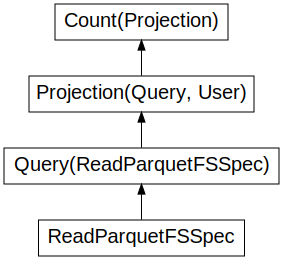

In [40]:
ddf2.query("Year == 2010")["User"].count().visualize()

To fully utilized hive partition must definded filtering at `read_parquet` command. No predicate pushdown at query optimization like Spark.

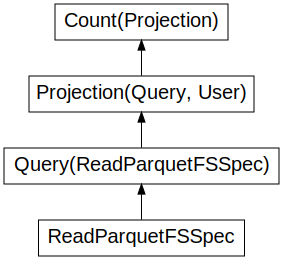

In [41]:
parquet_path = Path("data_combined_with_hive_sort_idx_no_div.parquet")
year_2010 = dd.read_parquet(parquet_path, filters=[("Year", "==", 2010)])
year_2010.query("Year == 2010")["User"].count().visualize()

In [42]:
%%timeit
year_2010.query("Year == 2010")["User"].count().compute()

916 ms ± 67.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
